In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import tqdm.notebook as tqdm
import itertools
import random

%matplotlib widget


In [2]:
W, H, D = 10, 10, 10         # width, height, depth
gen = random.Random(43)
Gfull = nx.Graph()
for x, y, z in itertools.product(range(W), range(H), range(D)):
    Gfull.add_node((x, y, z))

# 6-neighbour edges
for x, y, z in Gfull.nodes:
    for dx, dy, dz in [(-1,0,0),(1,0,0),(0,-1,0),(0,1,0),(0,0,-1),(0,0,1)]:
        nb = (x+dx, y+dy, z+dz)
        if nb in Gfull:               # stays inside the box
            Gfull.add_edge((x, y, z), nb, weight=gen.random())
len(Gfull.nodes), len(Gfull.edges)

(1000, 2700)

In [3]:
# run a Prim's algorithm to find the minimum spanning tree
maze = nx.minimum_spanning_tree(Gfull)


In [4]:
# generate a random rary tree
# G = nx.navigable_small_world_graph(3, dim=3, r=3)
# #renumber the nodes
G = nx.convert_node_labels_to_integers(maze, label_attribute="pos")

# pos = nx.spectral_layout(maze, dim=3)
# pos = nx.spring_layout(G2, k=0.1, dim=3, threshold=1e-6, weight=None)
# dict to array
# every node has a position from it's label
pos = np.array([G.nodes[i]["pos"] for i in G.nodes])
# normalize the positions (from 0 to 1)
pos = pos + np.random.rand(len(pos), 3) * 0.4
pos = pos - np.min(pos)
pos = pos / np.max(pos)
pos[:3]

array([[0.01114368, 0.01898124, 0.02302049],
       [0.03270631, 0.00528579, 0.1329197 ],
       [0.04160147, 0.01192661, 0.23185449]])

In [5]:
# slighly shift the positions

In [6]:
#start is top layer center
start = (W//2, H-1, D//2)
start_node = [x for x in G.nodes if G.nodes[x]["pos"] == start][0]
#end is bottom layer center
end = (W//2, 0, D//2)
end_node = [x for x in G.nodes if G.nodes[x]["pos"] == end][0]
correct_path = nx.shortest_path(G, start_node, end_node)
print(correct_path)

[595, 596, 696, 697, 797, 796, 786, 776, 766, 765, 755, 655, 555, 556, 557, 547, 447, 347, 337, 327, 227, 127, 126, 26, 16, 15, 14, 114, 124, 123, 23, 22, 122, 121, 221, 220, 320, 420, 421, 422, 412, 413, 403, 404, 405, 505]


/var/folders/r8/8vnnq62d4h96j1l_67m5x_m40000gn/T/ipykernel_17439/3238662016.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([pos[edge[0]][0], pos[edge[1]][0]],


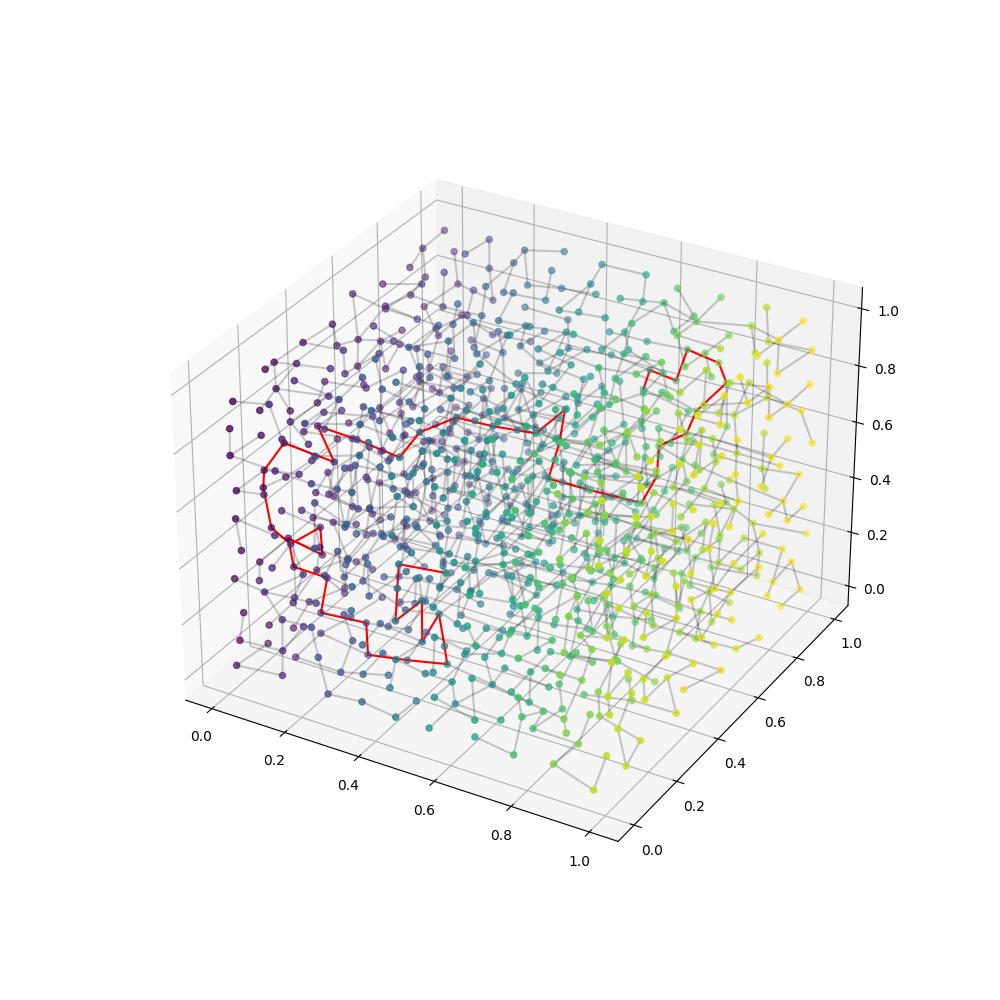

In [7]:
# draw the graph in 3d space
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c=range(len(pos)))
# show the edges
for edge in G.edges():
    is_correct = edge[0] in correct_path and edge[1] in correct_path
    ax.plot([pos[edge[0]][0], pos[edge[1]][0]], 
            [pos[edge[0]][1], pos[edge[1]][1]], 
            [pos[edge[0]][2], pos[edge[1]][2]], 
            'k-', alpha=1 if is_correct else 0.2, color="red" if is_correct else "black")
plt.show()

In [8]:
from typing import cast
import amulet
from amulet.api.level import World
from amulet.api.block import Block


INFO - PyMCTranslate Version 344


In [9]:
world = cast(
    World,
    amulet.load_level("labyrinth"),
)

world

INFO - Loading level labyrinth


In [10]:
LABYRINTH_SIZE = 162
STONE_BLOCk = Block("minecraft", "bedrock")
GLOWSTONE_BLOCK = Block("minecraft", "glowstone")
AIR_BLOCK = Block("minecraft", "air")



In [11]:
def pos_to_block(pos: np.ndarray) -> tuple[int, int, int]:
    return tuple(map(int, pos * (LABYRINTH_SIZE - 6) + 3))

In [12]:
world.dimensions

('minecraft:overworld', 'minecraft:the_nether', 'minecraft:the_end')

In [13]:
# set the whole labyrinth to stone
for x in tqdm.tqdm(range(LABYRINTH_SIZE)):
    for y in range(LABYRINTH_SIZE):
        for z in range(LABYRINTH_SIZE):
            world.set_version_block(x, y, z, "minecraft:overworld", ("java", (1, 21, 5)), STONE_BLOCk)


  0%|          | 0/162 [00:00<?, ?it/s]

In [14]:
# draw the vertices as 3x3x3 spaces
for i in tqdm.tqdm(range(len(pos))):
    x, y, z = pos_to_block(pos[i])
    for dx in range(-1, 2):
        for dy in range(-1, 2):
            for dz in range(-1, 2):
                world.set_version_block(x+dx, y+dy, z+dz, "minecraft:overworld", ("java", (1, 21, 5)), AIR_BLOCK)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
import math
def carve_air_line(x0, y0, z0, x1, y1, z1, world):
    """
    Places an AIR_BLOCK in every voxel on the Manhattan-connected line
    from (x0, y0, z0) to (x1, y1, z1).  No diagonal jumps.
    """

    # ── Reusable helper ────────────────────────────────────────
    def sign(a):   # returns −1, 0 or +1
        return (a > 0) - (a < 0)

    # Initial voxel
    world.set_version_block(x0, y0, z0,
                            "minecraft:overworld", ("java", (1, 21, 5)),
                            AIR_BLOCK)

    # Direction of travel on each axis
    stepX, stepY, stepZ = map(sign, (x1 - x0, y1 - y0, z1 - z0))

    # Absolute distances
    dx, dy, dz = abs(x1 - x0), abs(y1 - y0), abs(z1 - z0)

    # “How far until we cross the first voxel boundary” along each axis
    # (0.5 moves us to the next face because we start in the centre.)
    tMaxX = 0.5 / dx if dx else math.inf
    tMaxY = 0.5 / dy if dy else math.inf
    tMaxZ = 0.5 / dz if dz else math.inf

    # “How far we must move along the ray to cross *each* subsequent face”
    tDeltaX = 1.0 / dx if dx else math.inf
    tDeltaY = 1.0 / dy if dy else math.inf
    tDeltaZ = 1.0 / dz if dz else math.inf

    # Current voxel position
    x, y, z = x0, y0, z0

    # ── Main loop ───────────────────────────────────────────────
    while (x, y, z) != (x1, y1, z1):
        # Pick the axis whose voxel boundary is reached first
        if tMaxX <= tMaxY and tMaxX <= tMaxZ:
            x += stepX
            tMaxX += tDeltaX
        elif tMaxY <= tMaxZ:
            y += stepY
            tMaxY += tDeltaY
        else:
            z += stepZ
            tMaxZ += tDeltaZ

        world.set_version_block(x, y, z,
                                "minecraft:overworld", ("java", (1, 21, 5)),
                                AIR_BLOCK)


In [16]:
# Draw all edges
for edge in tqdm.tqdm(G.edges()):
    pos1 = pos_to_block(pos[edge[0]])
    pos2 = pos_to_block(pos[edge[1]])
    carve_air_line(pos1[0], pos1[1], pos1[2],
                 pos2[0], pos2[1], pos2[2], world)

  0%|          | 0/999 [00:00<?, ?it/s]

In [20]:
for i in correct_path:
    x, y, z = pos_to_block(pos[i])
    print(x, y, z)
    # world.set_version_block(x, y, z, "minecraft:overworld", ("java", (1, 21, 5)), GLOWSTONE_BLOCK)


87 158 92
90 158 104
104 153 106
106 158 121
122 152 123
122 158 108
122 136 106
124 123 103
121 108 104
121 107 88
124 90 87
105 86 89
87 87 87
91 88 109
92 91 125
90 74 122
74 70 122
58 72 120
53 55 121
56 37 120
36 40 120
20 40 122
25 42 103
4 42 105
6 25 103
5 26 92
8 26 71
19 21 70
22 36 69
21 38 53
7 37 57
9 38 41
20 42 36
20 38 19
40 37 22
40 38 3
55 41 5
72 41 9
73 38 22
70 38 39
73 22 36
72 24 57
71 8 57
72 8 75
74 6 91
92 8 92


In [18]:
world.save()

INFO - Saving changes to level labyrinth
INFO - Finished saving changes to level labyrinth


In [19]:
world.close()